# Activity 4.2. Document Clustering
In this activity, we study the performance of KMeans algorithm on a document clustering problem. 


*The followings are partly barrowed from: http://michael.hahsler.net/SMU/CSE7337/install/tm.R*

## Data
We use a subset of a publicly available dataset called 20 Newsgroups originally published in http://qwone.com/~jason/20Newsgroups/. This dataset contains more than 18K documents covering 20 different topics. For the simplicity and reducing the execution and evaluation times, we only use 1000 samples randomly selected from 4 categories. The filtered data is stored in `20ng-train-all-terms.txt` file.

In [1]:
## save the random seed to make the results reproducble
set.seed(12345) 

## read the file (each line of the text file is one document)
text <- readLines('./20ng-train-all-terms.txt')

## randomly select some samples
index <- sample(length(text), 400)
text  <- text[index]

## the terms before '\t' are the lables (the newsgroup names) and 
### all the remaining text after '\t' are the actual documents
docs <- strsplit(text, '\t')
rm(text) # just free some memory!

# store the labels for evaluation
labels <-  unlist(lapply(docs, function(x) x[1]))

# store the unlabeled texts    
docs <- data.frame(unlist(lapply(docs, function(x) x[2])))
                                 
## Update docs so it can be passed to DataframeSource - it requires an index
docs <- cbind(index,docs)
names(docs) <- c('doc_id','text')
     
head(docs)

doc_id,text
<int>,<fct>
1711,re help for kidney stones in article apr wvnvms wvnet edu pk wvnvms wvnet edu writes my girlfriend is in pain from kidney stones she says that because she has no medical insurance she cannot get them removed my question is there any way she can treat them herself or at least mitigate their effects any help is deeply appreciated advice referral to literature etc thank you dave carvell pk wvnvms wvnet edu first let me offer you my condolences i ve had kidney stones times and i know the pain she is going through first it is best that she see a doctor however every time i had kidney stones i saw my doctor and the only thing they did was to prescribe some pain killers and medication for a urinary tract infection the pain killers did nothing for me kidney stones are extremely painful my stones were judged passable so we just waited it out however the last one took days to pass not fun anyway if she absolutely won t see a doctor i suggest drinking lots of fluids and perhaps an over the counter sleeping pill but i do highly suggest seeing a doctor kidney stones are not something to fool around with she should be x rayed to make sure there is not a serious problem steve
2078,first spacewalk at one time there was speculation that the first spacewalk alexei leonov was a staged fake has any evidence to support or contradict this claim emerged was this claim perhaps another fevered cold war hallucination fred baube tm in times of intellectual ferment baube optiplan fi advantage to him with the intellect include disclaimer h most fermented how is frank zappa doing may paris it s retrospective time
1805,el sets i am looking for a source of orbital element sets other than uaf space command i believe there is one on compuserve please let me know what other possible sources there are and how i can reach them thanks much
2101,boom whoosh and one of my profs is the chief engineer for the project dr ron humble univ colorado at colorado springs i love the idea of an inflatable mile long sign it will be a really neat thing to see it explode when a bolt or even better a westford needle comes crashing into it at clicks a sec boom whooooooooshhhhhh sputter sputter okay pretend it would make a sound i hear insert favorite rumor here that it will supposedly coincide with the atlanta olympics fuzzy lt david fuzzy wells i want peace on earth o o hq afspacecom cna goodwill toward men we do debris we re the government we don t do that u ack wdwells esprit uccs edu that sort of thing sneakers
1082,electronic parts in nyc hey all i just moved to nyc and wondered if there are any electronics hackers out there who could point me to places in nyc that sell individual electronic components switches pots transformers caps transistors etc radio shack doesn t count they have almost no selection and their prices are outrageous i have particular interest in audio components amplifier ic s power mosfets output transformers tubes and tube sockets pan pots faders etc i have checked out a lot of th street and canal street so far with no luck am i missing places looking in the wrong place or do i have to resort to mail order thanks in advance fritzm
394,pseudo random character generators large state here are four pseudo random character generators based on irreducible trinomials each contains separate trinomials one of which is selected on initialization there are distinct trinomials between the prcgs the prcgs are initialized with a bit seed and a bit trinomial selector i would like to get comments on these by anyone who is interested enough to look them over please email because our news is on the fritz note that this was posted via email peter k boucher boucher csl sri com clip clip


## Feature Extraction
Prior doing any clustering, we need to extract some meaningful features from the datasets. The features should be numerical, otherwise our Euclidean distance (non-similarity) measure will not work. To do so, we use a popular R package called `tm` to tailor the texts and calculate word counts (frequency of each word in each single document) as the features.

In [2]:
# load Text Mining library
library(NLP)
library(tm)

# create a corpus
docs <- DataframeSource(docs)
docs <- Corpus(docs)
docs

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 400

In [3]:
# Preprocessing:
docs <- tm_map(docs, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
docs <- tm_map(docs, removePunctuation) # remove pnctuation
docs <- tm_map(docs, stemDocument)      # perform stemming (reducing inflected and derived words to their root form)
docs <- tm_map(docs, removeNumbers)     # remove all numbers
docs <- tm_map(docs, stripWhitespace)   # remove redundant spaces 

# Create a matrix which its rows are the documents and colomns are the words. 
## Each number in Document Term Matrix shows the frequency of a word (colomn header) in a particular document (row title)
dtm <- DocumentTermMatrix(docs)
dtm

<<DocumentTermMatrix (documents: 400, terms: 8913)>>
Non-/sparse entries: 39891/3525309
Sparsity           : 99%
Maximal term length: 20
Weighting          : term frequency (tf)

As there are too many terms with very low frequency of occurrence, we will reduce the sparcity of the feature space by filtering out very low frequency terms.

In [4]:
## reduce the sparcity of out dtm
dtm <- removeSparseTerms(dtm, 0.90)
dtm

dtm.m <- as.matrix(dtm)
head(cbind(labels, dtm.m))

<<DocumentTermMatrix (documents: 400, terms: 125)>>
Non-/sparse entries: 8553/41447
Sparsity           : 83%
Maximal term length: 8
Weighting          : term frequency (tf)

,labels,apr,articl,can,day,edu,effect,etc,everi,first,⋯,actual,phone,seem,give,fact,follow,gov,experi,issu,call
1711,sci.med,1,1,1,1,3,1,1,1,2,⋯,0,0,0,0,0,0,0,0,0,0
2078,sci.space,0,0,0,0,0,0,0,0,2,⋯,0,0,0,0,0,0,0,0,0,0
1805,sci.space,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2101,sci.space,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1082,sci.electronics,0,0,0,0,0,0,2,0,0,⋯,0,0,0,0,0,0,0,0,0,0
394,sci.crypt,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## Document Clustering with Kmeans
Let's assume we know the real number of clusters (4 newsgroups). Later on, we cn try other values and study their results.

In [5]:
kmeans(dtm.m,4)

K-means clustering with 4 clusters of sizes 1, 379, 4, 16

Cluster means:
        apr    articl        can       day        edu    effect       etc
1 0.0000000 6.0000000 24.0000000 4.0000000 42.0000000 6.0000000 6.0000000
2 0.2691293 0.5593668  0.7836412 0.1609499  0.9419525 0.1556728 0.1319261
3 0.0000000 0.2500000  4.2500000 1.2500000  1.0000000 0.7500000 3.7500000
4 0.1250000 0.9375000  6.3125000 0.6875000  1.0625000 0.6250000 0.5625000
      everi      first        get      help      high       just       know
1 6.0000000  5.0000000 12.0000000 8.0000000 2.0000000 11.0000000 15.0000000
2 0.1134565  0.1662269  0.5065963 0.1635884 0.1556728  0.3799472  0.4353562
3 1.0000000 13.2500000  1.5000000 0.2500000 5.2500000  1.7500000  1.2500000
4 1.1250000  1.1875000  2.2500000 0.2500000 0.7500000  1.5000000  0.8750000
       least       let       lot       make        one   problem  question
1 1.00000000 7.0000000 8.0000000 10.0000000 28.0000000 7.0000000 7.0000000
2 0.09762533 0.1240106 0.1

### Visualization
Recal that our feature space is a high-dimensional one and we cannot plot all the dimensions. Therefore, we perform a PCA and only plot the first two principle components ( components with the largest eigenvalues). In the followings we plot these PCs and color the points according to the real and estimated clusters.

**Note:** The color codes can be different in these plots as the cluster orders, and hence their labels and colors, can be different.


Attaching package: ‘ggplot2’

The following object is masked from ‘package:NLP’:

    annotate



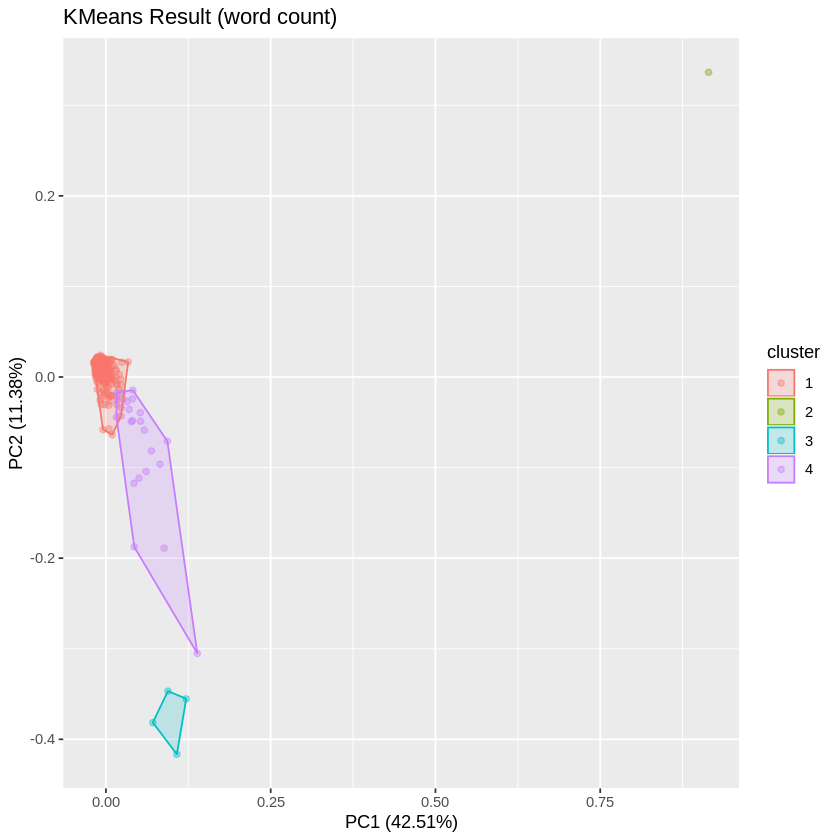

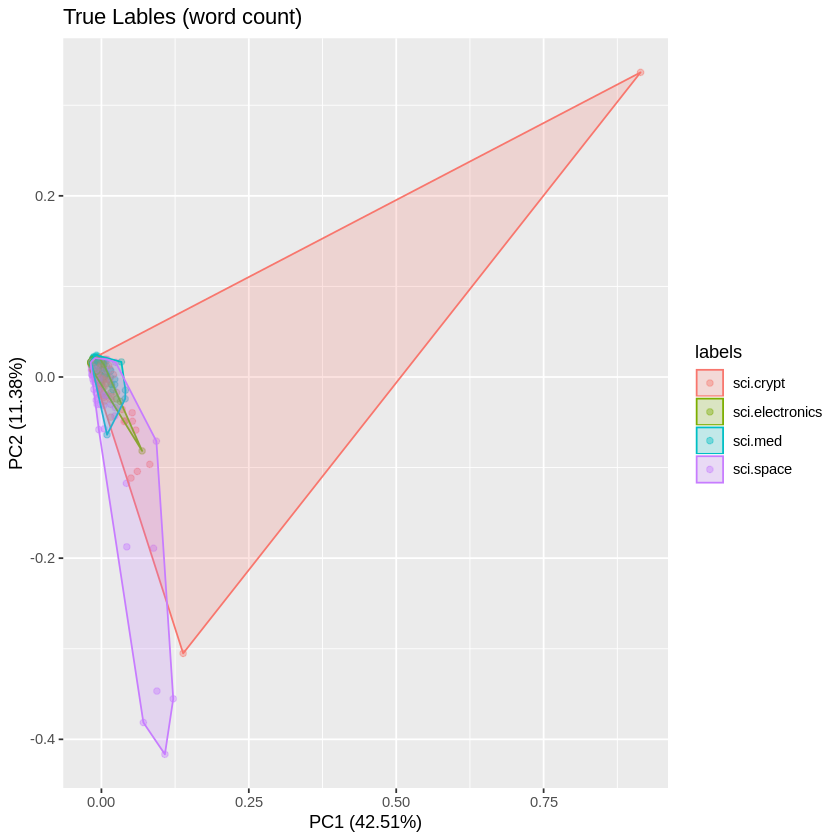

In [6]:
library(ggplot2)
library(ggfortify)
autoplot(kmeans(dtm.m,4), 
         data=dtm.m, 
         frame = TRUE, 
         alpha = 0.4, 
         main='KMeans Result (word count)')
autoplot(prcomp(dtm.m,4), 
         data=cbind(dtm.m, labels), 
         colour = 'labels',
         frame = TRUE, 
         alpha = 0.4, 
         main='True Lables (word count)')

## A Simple Normalization
As the above figures show, in some cases the data samples are located far from each other, while in some other cases, they are colocated. ALso note that the scale of PCs can be very different. This suggests that with a normalization we might get better result as the performance of Kmeans is very sensitive to the distance between the points.

In [7]:
## define an auxiliary function that calculates euclidian normalization

norm.eucl <- function(m) m/apply(m, MARGIN=1, FUN=function(x) sum(x^2)^.5)  ## apply sum(x^2)*0.5 to all distances
dtm.n <- norm.eucl(dtm.m) 
dtm.n[is.na(dtm.n)] <- 0  # make in NAs 0

head(cbind(labels, dtm.m))
head(cbind(labels, round(dtm.n,2)))                               

,labels,apr,articl,can,day,edu,effect,etc,everi,first,⋯,actual,phone,seem,give,fact,follow,gov,experi,issu,call
1711,sci.med,1,1,1,1,3,1,1,1,2,⋯,0,0,0,0,0,0,0,0,0,0
2078,sci.space,0,0,0,0,0,0,0,0,2,⋯,0,0,0,0,0,0,0,0,0,0
1805,sci.space,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2101,sci.space,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1082,sci.electronics,0,0,0,0,0,0,2,0,0,⋯,0,0,0,0,0,0,0,0,0,0
394,sci.crypt,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


,labels,apr,articl,can,day,edu,effect,etc,everi,first,⋯,actual,phone,seem,give,fact,follow,gov,experi,issu,call
1711,sci.med,0.13,0.13,0.13,0.13,0.4,0.13,0.13,0.13,0.27,⋯,0,0,0,0,0,0,0,0,0,0
2078,sci.space,0,0,0,0,0,0,0,0,0.52,⋯,0,0,0,0,0,0,0,0,0,0
1805,sci.space,0,0,0.32,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2101,sci.space,0,0,0,0,0.21,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1082,sci.electronics,0,0,0,0,0,0,0.43,0,0,⋯,0,0,0,0,0,0,0,0,0,0
394,sci.crypt,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


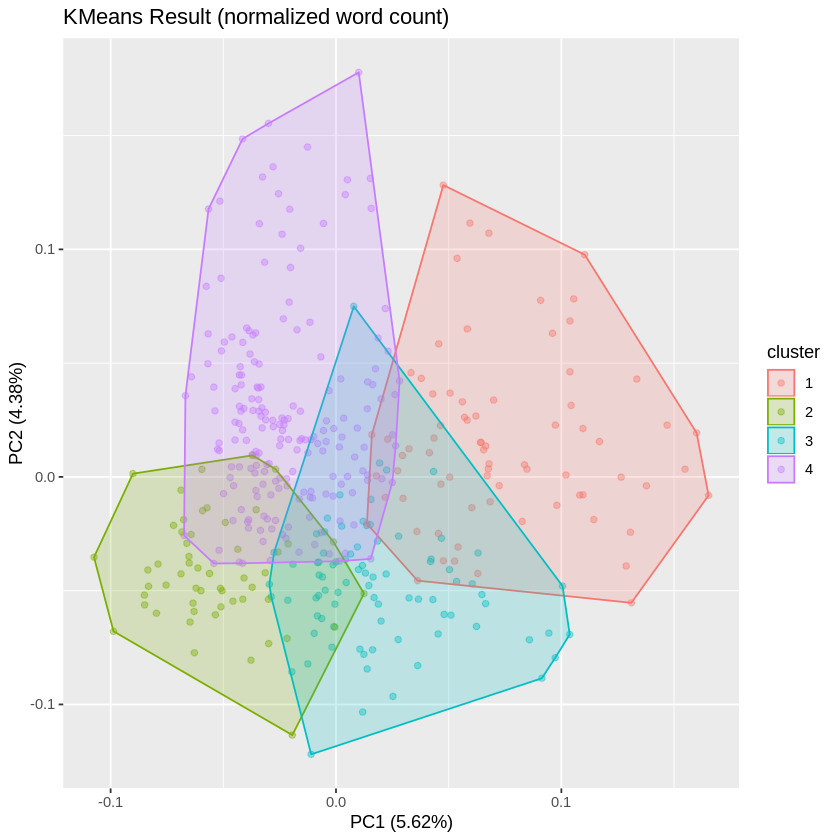

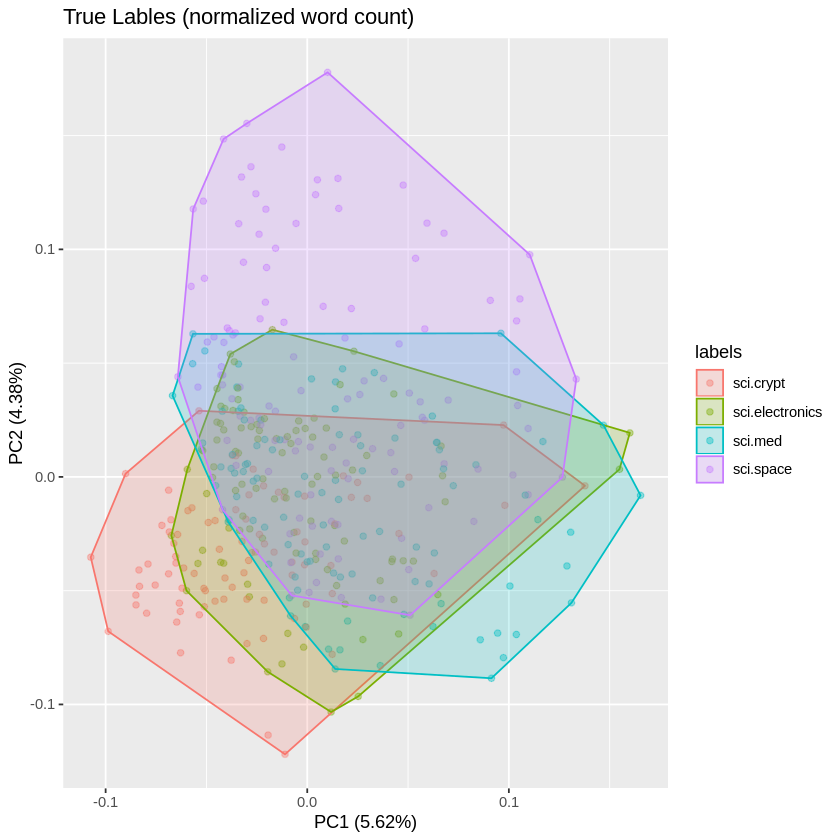

In [8]:
autoplot(kmeans(dtm.n,4), 
         data=dtm.n, 
         frame = TRUE, 
         alpha = 0.4, 
         main='KMeans Result (normalized word count)')
autoplot(prcomp(dtm.n,4), 
         data=cbind(dtm.n, labels), 
         colour = 'labels',
         frame = TRUE, 
         alpha = 0.4, 
         main='True Lables (normalized word count)')
                                

## A More Advanced Set of Features

The simple normalization improved Kmeans outcome, but not that much. This suggests that not only the initialization and number of clusters have great impact on the kmeans outcome, but the feature space itself should be discriminative as well. In the followings, we try another feature (instead of the simple word counts) that is knonw as Term Frequency-Inverse Document Frequency (TFIDF). In its core, TFIDF in nothing but weighted word count.

Let's calculate TFIDF feature values and then repeat the above experimetns.

In [9]:
## calculate the tfidf weights
tfidf   <- weightTfIdf(dtm)
tfidf.m <- as.matrix(tfidf)

## Let normalize (using euclidian distance) the tfidf weights and repeat the experiments
tfidf.n <- norm.eucl(tfidf.m)
tfidf.n[is.na(tfidf.n)] <- 0

cat('Term Frequency')
head(cbind(labels, dtm.m))

cat('TF-IDF')
head(cbind(labels, round(tfidf.n,2)))

cat('Normalised TF-IDF')
head(cbind(labels, round(tfidf.m,2)))

Term Frequency

,labels,apr,articl,can,day,edu,effect,etc,everi,first,⋯,actual,phone,seem,give,fact,follow,gov,experi,issu,call
1711,sci.med,1,1,1,1,3,1,1,1,2,⋯,0,0,0,0,0,0,0,0,0,0
2078,sci.space,0,0,0,0,0,0,0,0,2,⋯,0,0,0,0,0,0,0,0,0,0
1805,sci.space,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2101,sci.space,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1082,sci.electronics,0,0,0,0,0,0,2,0,0,⋯,0,0,0,0,0,0,0,0,0,0
394,sci.crypt,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


TF-IDF

,labels,apr,articl,can,day,edu,effect,etc,everi,first,⋯,actual,phone,seem,give,fact,follow,gov,experi,issu,call
1711,sci.med,0.13,0.07,0.06,0.16,0.17,0.18,0.18,0.18,0.3,⋯,0,0,0,0,0,0,0,0,0,0
2078,sci.space,0,0,0,0,0,0,0,0,0.6,⋯,0,0,0,0,0,0,0,0,0,0
1805,sci.space,0,0,0.13,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2101,sci.space,0,0,0,0,0.09,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1082,sci.electronics,0,0,0,0,0,0,0.44,0,0,⋯,0,0,0,0,0,0,0,0,0,0
394,sci.crypt,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Normalised TF-IDF

,labels,apr,articl,can,day,edu,effect,etc,everi,first,⋯,actual,phone,seem,give,fact,follow,gov,experi,issu,call
1711,sci.med,0.06,0.03,0.03,0.07,0.08,0.08,0.08,0.08,0.14,⋯,0,0,0,0,0,0,0,0,0,0
2078,sci.space,0,0,0,0,0,0,0,0,0.72,⋯,0,0,0,0,0,0,0,0,0,0
1805,sci.space,0,0,0.1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2101,sci.space,0,0,0,0,0.05,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1082,sci.electronics,0,0,0,0,0,0,0.43,0,0,⋯,0,0,0,0,0,0,0,0,0,0
394,sci.crypt,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


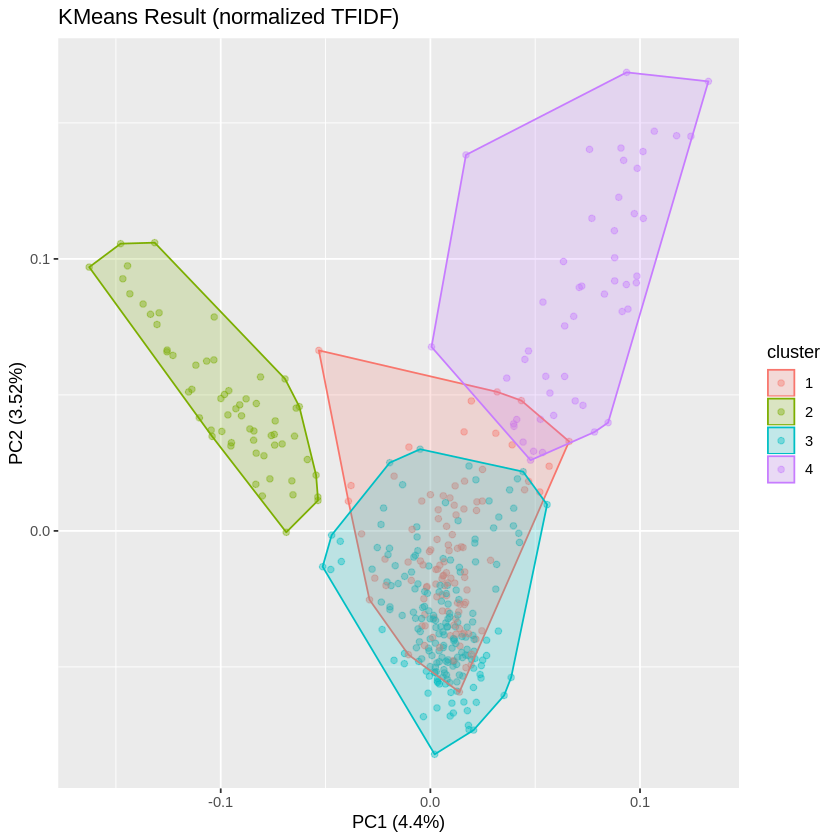

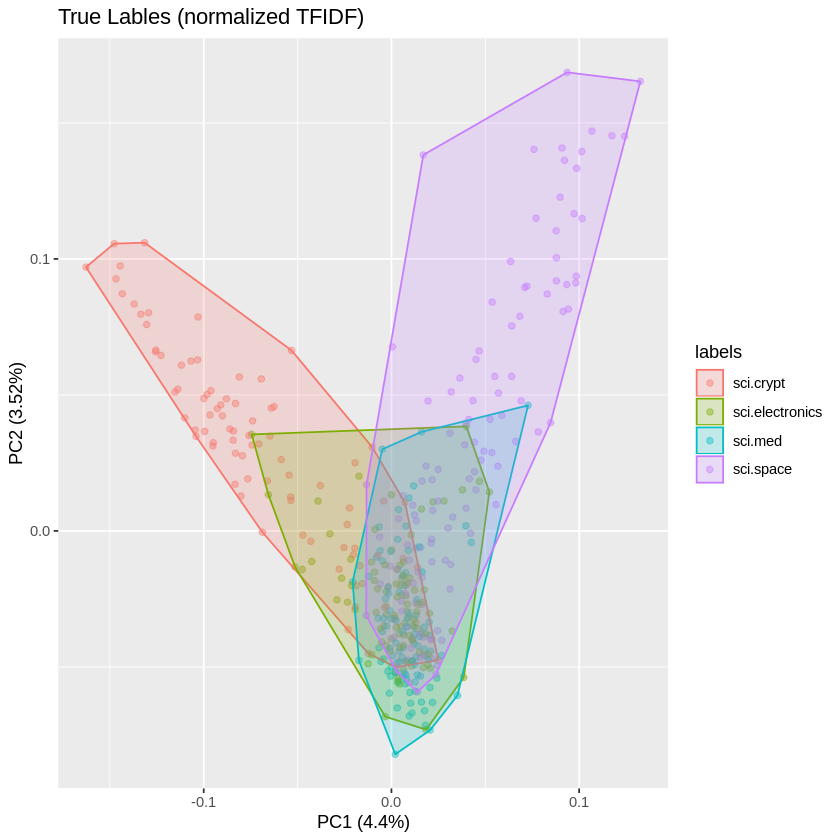

In [10]:
autoplot(kmeans(tfidf.n,4), 
         data=tfidf.n, 
         frame = TRUE, 
         alpha = 0.4, 
         main='KMeans Result (normalized TFIDF)')
autoplot(prcomp(tfidf.n,4), 
         data=cbind(tfidf.n, labels), 
         colour = 'labels',
         frame = TRUE, 
         alpha = 0.4, 
         main='True Lables (normalized TFIDF)')                      

## Discussions:
1- We knew that KMeans is very sensitive to its initialzation (initial cluster centers) and number of clusters (`k`). Apart from that, what is the other main limitation of Kmeans algorithm (**Hint:** Think of feature set and distance metric)?

2- Given the limitaitons we count in the previous question, what could be the remedy (**Hint:** Think of EM techniques that are covered in the previous chapter)?